# Special method `CFMR7osc` for oscillatory problems

This method is special in the sense that [Calvo, Franco, Montijano and Rández](https://doi.org/10.1016/S0377-0427(96)00103-3) have created this method especially for initial value problems with oscillating solutions. However, I think that it can solve many other problems efficiently as well, as long as the demanded tolerance is relatively low (lower than the default). It even bests `DOP853`, which is a higher order method, in many cases.

## The method

The trick of Calvo is use the degrees of freedom in the coefficients not to improve all higher order (above 7) error constants, but only those that reduce the dissipation and dispersion errors. This results in a method that has a 7th order algebraic error, but a 9th order dissipation error and a 10th order dispersion error!

The graph of the stability region shows that part of the imaginary axis (below 1.7) falls just outside the stability region. The boundary is probably close enough; this is what the method was designed for after all (low dissipation error).

![Stability regions](stability%20regions/stabilityCFMR7osc.png)

The [paper](https://doi.org/10.1016/S0377-0427(96)00103-3) does not contain the coefficients of an interpolant. I have created one of (algebraic) order 5, like the embedded method, that is C1-continuous, and free (no extra evaluations of the derivative function are needed). I have used the remaining degrees of freedom to make $||T_{20}^{(6)}||$ zero. This results in a 6th order dispersion error and a 7th order dissipation error for the interpolant. This aligns with the idea of the paper, result in relatively nice coefficients, and the other 6th order error constants turn out to be acceptably low.

![interpolant](interpolants/interpolation_CFMR7osc.png)

## Demo on an oscillatory problem

The first problem is a forced mass spring system with a long integration interval. This is not the most exciting problem, but it is a typical problem that this method was designed for.


In [17]:
import numpy as np
from math import sin

T_end = 1000.
problem = {'fun' : lambda t, y: [y[1], -100. * y[0] + 99. * sin(t)],
            'y0' : [1., 11.],
        't_span' : [0., T_end]}

def reference(t):
    y = np.cos(10. * t) + np.sin(10. * t) + np.sin(t)
    dy = 10. * (np.cos(10. * t) - np.sin(10. * t)) + np.cos(t)
    return np.array([y, dy])

def rms_err_norm(solution, reference=reference):
    error = solution.y - reference(solution.t)
    err_norm = (error**2).mean()**0.5
    return err_norm

The initial value problem, its analytic solution and a function that calculates the root mesn square error of the numerical solution are defined above.

Next, we solve this problem at tighter than default tolerance with `CFMR7osc` and 'DOP853' (Scipy's higher order method).

		fun evals 	   error
CFMR7osc: 	  109091 	 3.32e-03
DOP853: 	  121361 	 3.34e-02


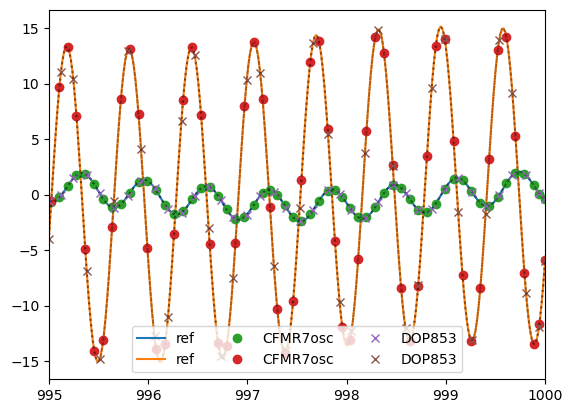

In [18]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from extensisq import CFMR7osc, Pr8

methods = {"CFMR7osc":CFMR7osc, "DOP853":"DOP853"}

solutions = []
for method in methods.values():
    solutions.append(solve_ivp(**problem, method=method, rtol=1e-5, atol=1e-8, 
                     dense_output=True))

t = np.linspace(T_end - 5., T_end, 300)
plt.plot(t, reference(t).T, label='ref')

print('\t\tfun evals \t   error')
for method, sol, marker in zip(methods, solutions, ['o', 'x']):
    print(f'{method}: \t  {sol.nfev} \t {rms_err_norm(sol):5.2e}')
    plt.plot(sol.t, sol.y.T, marker, label=method)
    plt.plot(t, sol.sol(t).T, 'k:', alpha=0.3)     # to show interpolants

plt.xlim(T_end - 5., T_end)
plt.legend(ncol=3)
plt.show()

Both solutions look good in the graph which shows only the last part of the integration. The interpolants look good too. The table lists the effort in number of function evaluations and the error of the solution for each method. The error of `CFMR7osc` is 10 times lower than the error of 'DOP853' in this case. Moreover, `CFMR7osc` achieves this with about 10% fewer function evaluations. 

## Non-linear problem

I would like to show that it `CFMR7osc` can be efficient non-oscilatory, non-linear problems as well. Problem B3 from the [DETEST](http://perso.ensta-paristech.fr/~chapoutot/integration/docs/p1-enright.pdf) set is used to demonstrate this. It is a  non-linear chemical reaction.

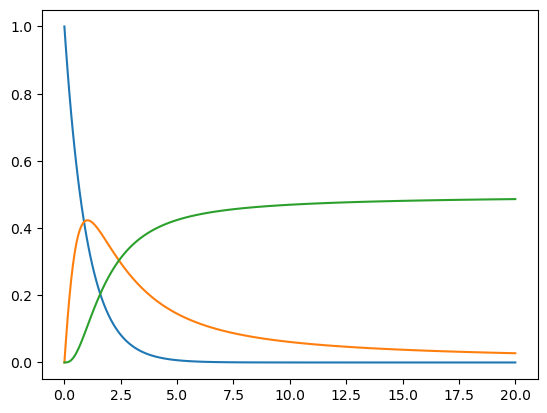

		fun evals 	   error
CFMR7osc: 	  275 		 1.46e-10
DOP853: 	  332 		 5.72e-10


In [19]:
problem2 = {'fun': lambda x, y: [-y[0], y[0]-2*y[1]**2, y[1]**2],
        't_span' : [0., 20.],
             'y0': [1., 0., 0.]}

sol_ref = solve_ivp(**problem2, method=Pr8, atol=1e-10, rtol=1e-10, 
                    dense_output=True)

plt.plot(sol_ref.t, sol_ref.y.T)
plt.show()

solutions2 = []
for method in methods.values():
    solutions2.append(solve_ivp(**problem2, method=method,
                                atol=1e-9, rtol=1e-6, 
                                dense_output=True))

print('\t\tfun evals \t   error')
for method, sol in zip(methods, solutions2):
    print(f'{method}: \t  {sol.nfev} \t\t {rms_err_norm(sol, reference=sol_ref.sol):5.2e}')


The figure shows that the solution of this problem is not oscillatory. Yet `CFMR7osc` beats 'DOP853' at nr of function evaluations and error. Notice that the dense output is requested, which results in extra function evaluations for 'DOP853'. If this is turned off, then the number of evaluations will drop just below that of `CFMR7osc`, leaving only the edge in error. Nevertheless, this is a remarkable performance for a lower order method (7 vs 8) that is tuned to a completely different kind of problem.

## Conclusion

I am pleasantly surprised by the effectiveness of this little known method. `CFMR7osc` is a great explicit method for integrating oscillatory problems over long intervals. With the free interpolant, it can beat 'DOP853' at a wide range of problems (although only one example is shown here). If you need to solve a non-stiff problem at high accuracy, give `CFMR7osc` a try.